In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
class LayerDense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.rand(n_inputs, n_neurons) - 0.5
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs


    def backward(self, d_values):
        self.dweights = np.dot(self.inputs.T, d_values)
        self.dbiases = np.sum(d_values, axis=0, keepdims=True)
        self.dinputs = np.dot(d_values, self.weights.T)

In [80]:
class ActivationReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, d_values):
        self.dinputs = d_values.copy()
        self.dinputs[self.inputs <= 0] = 0

In [81]:
class ActivationSoftmaxLossCategoricalCrossentropy:
    def forward(self, inputs, correct_labels):
        print(inputs)
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) # -np.max(...) for numerical stability with big number
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        samples = len(self.output)
        predictions = np.clip(self.output, 1e-7, 1 - 1e-7)
        correct_predictions = predictions[range(samples), correct_labels]
        per_sample_losses = -np.log(correct_predictions)
        return np.mean(per_sample_losses)

    def backward(self, dvalues, correct_labels):
        samples = len(dvalues)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), correct_labels] -= 1
        self.dinputs /= samples

In [70]:
class OptimizerSGD:
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        
        weight_updates = -self.learning_rate * layer.dweights
        bias_updates = -self.learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates


In [71]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(n_images, n_rows, n_cols)
        return images, n_images

def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = np.frombuffer(data, dtype=np.uint8, offset=8)
        return labels


In [72]:
x, num_inputs = read_mnist_images('mnist/train-images.idx3-ubyte')
y = read_mnist_labels('mnist/train-labels.idx1-ubyte')

In [86]:
epochs = 100
batch_size = 60
X, Y = x / 255., y
Y = Y.reshape(-1, 1) 
X = X.reshape(-1, 784)
dense1 = LayerDense(784, 10) 
activation1 = ActivationReLU() 
dense2 = LayerDense(10, 10)
activation2 = ActivationSoftmaxLossCategoricalCrossentropy()
optimizer = OptimizerSGD()

for i in range(epochs):
    for j in range(0, len(X), batch_size):
        X_batch = X[j:j+batch_size]
        Y_batch = Y[j:j+batch_size]
        dense1.forward(X_batch)
        activation1.forward(dense1.output)
        print(activation1.output)
        dense2.forward(activation1.output)
        data_loss = activation2.forward(dense2.output, Y_batch)
        loss = data_loss
        predictions = np.argmax(activation2.output, axis=1)
        accuracy = np.mean(predictions == Y_batch)
        activation2.backward(activation2.output, Y_batch)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
    print(f'epoch: {i}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')

[[0.         0.         3.85251553 0.         0.         0.32546769
  0.         1.41646458 0.         2.91145519]
 [0.         1.32766406 1.43278769 0.         0.         3.85529492
  0.         3.09779267 3.07732851 0.        ]
 [2.13330503 0.         1.99493699 0.         2.09484807 0.84580445
  0.         1.8133675  2.77422242 0.        ]
 [0.         0.         1.39592976 0.         1.07698829 4.94334828
  0.         0.         0.         1.11911091]
 [1.75190606 0.         2.42812919 0.96551435 4.6623657  1.26832356
  0.         2.04175856 3.27282813 3.39276506]
 [4.16872752 1.99163535 2.52535992 2.22737861 3.11595385 1.80068477
  0.         2.81393414 0.         3.00385429]
 [0.         0.         3.89615903 0.         0.         2.39649049
  0.         0.         1.69426573 0.15665945]
 [2.19013598 0.         2.05278276 0.         0.         3.20291032
  0.         2.86112775 0.64271617 2.7917542 ]
 [0.09001589 0.         2.31873147 0.72724771 0.68328053 0.34150054
  0.        

/var/folders/y0/sj5bvt0j4qvf3hsh01p94f8h0000gn/T/ipykernel_31590/3391973854.py:4: RuntimeWarning: invalid value encountered in subtract
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) # -np.max(...) for numerical stability with big number


[[nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan n

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0. nan nan nan nan]
 [nan nan n

KeyboardInterrupt: 

In [88]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [89]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(n_images, n_rows, n_cols)
        return images, n_images


def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = np.frombuffer(data, dtype=np.uint8, offset=8)
        return labels


x, num_inputs = read_mnist_images('mnist/train-images.idx3-ubyte')
x = x.reshape(-1, 784)
x = x / 255.
y = one_hot_encode(read_mnist_labels('mnist/train-labels.idx1-ubyte'), 10)

In [106]:
w1 = np.random.rand(784, 10) - 0.5 # column per neuron, row per input
b1 = np.zeros(10).reshape(1,-1)
w2 = np.random.rand(10, 10) - 0.5
b2 = np.zeros(10).reshape(1,-1)

In [107]:
def relu(x):
    return np.maximum(0, x)

In [108]:
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

In [111]:
def forward_propagation(x_batch, y_batch, w1, b1, w2, b2):
    z1 = np.dot(x_batch, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = softmax(z2)
    loss = np.sum(-np.log(a2) * y_batch)
    return z1, a1, z2, a2, loss


def backward_propagation(x_batch, y_batch, z1, a1, a2, w2):
    samples = len(x_batch)
    dZ2 = a2 - y_batch
    dW2 = np.dot(a1.T, dZ2) / samples
    db2 = np.sum(dZ2, axis=0, keepdims=True) / samples
    dZ1 = np.dot(dZ2, w2.T) / samples
    dZ1[z1 <= 0] = 0
    dW1 = np.dot(x_batch.T, dZ1) / samples
    db1 = np.sum(dZ1, axis=0, keepdims=True) / samples
    return dW1, db1, dW2, db2


def update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, learning_rate):
    w1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dW2
    b2 -= learning_rate * db2.reshape(1, -1)
    return w1, b1, w2, b2


def run_network(x, y, w1, b1, w2, b2, learning_rate, epochs, batch_size):
    for i in range(epochs):
        for j in range(0, len(x), batch_size):
            x_batch = x[j:j+batch_size]
            y_batch = y[j:j+batch_size]
            z1, a1, z2, a2, loss = forward_propagation(x_batch, y_batch, w1, b1, w2, b2)
            dW1, db1, dW2, db2 = backward_propagation(x_batch, y_batch, z1, a1, a2, w2)
            w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, learning_rate)
            accuracy = np.mean(np.argmax(a2, axis=1) == np.argmax(y_batch, axis=1))
        print(f'epoch: {i}, loss: {loss}', f'acc: {accuracy:.3f}')
    return w1, b1, w2, b2

In [112]:
run_network(x, y, w1, b1, w2, b2, 0.1, 100, 60)

epoch: 0, loss: 68.62185684134681 acc: 0.567
epoch: 1, loss: 59.39637096106717 acc: 0.633
epoch: 2, loss: 51.84373862034248 acc: 0.667
epoch: 3, loss: 46.03141379764037 acc: 0.717
epoch: 4, loss: 41.46035877464296 acc: 0.767
epoch: 5, loss: 37.82684784554139 acc: 0.767
epoch: 6, loss: 34.965843232417456 acc: 0.783
epoch: 7, loss: 32.68150227276578 acc: 0.833
epoch: 8, loss: 30.746798050016114 acc: 0.833
epoch: 9, loss: 29.130516186253864 acc: 0.850
epoch: 10, loss: 27.745920228753654 acc: 0.850
epoch: 11, loss: 26.564351500067822 acc: 0.850
epoch: 12, loss: 25.492075590127577 acc: 0.883
epoch: 13, loss: 24.567553706978007 acc: 0.900
epoch: 14, loss: 23.75885541506846 acc: 0.917
epoch: 15, loss: 23.034006104923268 acc: 0.917
epoch: 16, loss: 22.392860634561696 acc: 0.917
epoch: 17, loss: 21.83225351845656 acc: 0.917
epoch: 18, loss: 21.33625148443803 acc: 0.917
epoch: 19, loss: 20.889520643183893 acc: 0.933
epoch: 20, loss: 20.487947262436258 acc: 0.933
epoch: 21, loss: 20.1290319106550

(array([[-0.30568667,  0.08216111,  0.24655292, ..., -0.24389695,
          0.36517454, -0.47602579],
        [-0.37954433,  0.28976872,  0.37714034, ..., -0.28089931,
          0.17805563, -0.27208733],
        [-0.36769763,  0.0375225 , -0.28643863, ...,  0.33290355,
         -0.20914793, -0.28010473],
        ...,
        [ 0.32508396,  0.30507554,  0.15377305, ...,  0.39468545,
          0.07197811, -0.29339456],
        [ 0.36273376,  0.38368134,  0.0333614 , ..., -0.3117535 ,
          0.45396944, -0.03874367],
        [-0.21313943, -0.4697434 , -0.09562315, ...,  0.00748295,
          0.49913972, -0.34847776]]),
 array([[ 0.27953097,  0.43484602,  0.08679978,  0.07027574, -0.09009629,
          0.07789391, -0.19920855,  0.08838469,  0.08312816,  0.06898432]]),
 array([[-0.6326944 ,  0.07711258, -0.90100539,  0.01713515,  1.26211373,
         -0.18753318, -0.89020279,  0.66083651,  0.11662644,  1.19524407],
        [-0.6001226 ,  0.62052728,  0.34386664,  0.4895087 , -0.12442423,

In [121]:
x_test, num_inputs = read_mnist_images('mnist/t10k-images.idx3-ubyte')
x_test_flat = x_test.reshape(-1, 784) / 255.
y_test = one_hot_encode(read_mnist_labels('mnist/t10k-labels.idx1-ubyte'), 10)
z1, a1, z2, a2, loss = forward_propagation(x_test_flat[85], y_test[85], w1, b1, w2, b2)
print(np.argmax(a2))
print(np.argmax(y_test[85]))


4
4


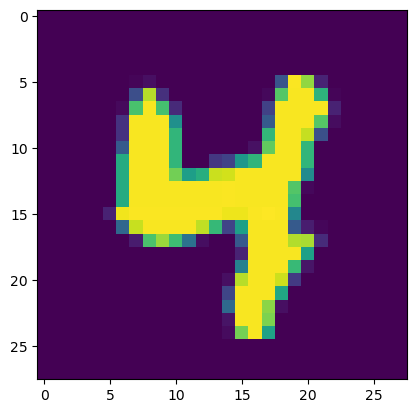

In [122]:
plt.imshow(x_test[85])